In [1]:
import numpy as np
import sys
import os
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import pickle as pkl

In [2]:
recalculate=False

MATH_type='MATHfree'
SPOP_type = 'WT'
reweighting = True
selected_phi_limit = 0.4
Ctot_crossvalidate = 15.0

oligomersizes = np.arange(2,61,2)
concs = [5.0, 10.0, 20.0, 30.0, 40.0]

if reweighting == True:
    reweighting_type = f'{SPOP_type}_{MATH_type}_reweighting_phieff{selected_phi_limit}'
else:
    reweighting_type = f'{SPOP_type}_{MATH_type}_noreweighting'
    
os.system(f'mkdir plots/{reweighting_type}')

mkdir: cannot create directory ‘plots/WT_MATHfree_reweighting_phieff0.4’: File exists


256

In [3]:
# Load weights
def load_weights(weightsfile):
    weights = np.genfromtxt(weightsfile, usecols=(1))
    return np.array(weights)

#Loads SAXS intensities calculated from simulations - in BME format
def load_sim_SAXS(calc_file):
    calc_data = np.array([[float(x) for x in line.split()[1:]] for line in open(calc_file) if("#" not in line)])
    return np.array(calc_data)

#Loads experimental SAXS q, I and err - in BME format
def load_exp_SAXS(exp_file):
    q, I, err = np.genfromtxt(exp_file, usecols=(0,1,2), skip_header=0, unpack=True)
    return np.array(q), np.array(I), np.array(err)


#Function to calculate chi2
def get_chi2(Iaverage_sim, I_exp, err_exp):
    
    chi2 = np.average(np.square((Iaverage_sim-I_exp)/err_exp))
    
    return chi2


# Function to calculate concentrations with isodesmic model

#Calculate concentrations with isodesmic model
#Returns array of oligomer concentrations
def isodesmic(Ka, Ctot, oligomersizes):
    
    #Get BTB dimer conc (fully formed)
    BTBdimer_conc = Ctot/2.0
    
    C = []
    
    #Calculate monomer concentration
    conc = (2*BTBdimer_conc*Ka+1-np.sqrt(4*BTBdimer_conc*Ka+1))/(2*BTBdimer_conc*(Ka**2))
    C.append(conc)
    
    #Calculate oligomer concentrations
    for i in range(1,len(oligomersizes)):
        conc = Ka*C[i-1]*C[0]
        C.append(conc)
        
    return np.array(C)


# Functions for SAXS and getting chi2

#Takes array of Iaverages from the different oligomers and calculates volume fraction weighted average SAXS using concs and oligomersizes
def volume_average_all_SAXS(calc_data, weights, concs, oligomersizes):
    Iaverages = np.sum(calc_data*weights[:,np.newaxis].reshape(calc_data.shape[0],calc_data.shape[1],1),axis=1)
    
    volume_weights = concs*oligomersizes
    volume_weights = volume_weights/np.sum(volume_weights)

    Iaverage_all = np.sum(Iaverages*volume_weights[:,np.newaxis],axis=0)
        
    return Iaverage_all


#Fit SAXS scale and offset between simulation and expt. SAXS with linear regression
def fit_scale_offset(Iaverage_sim, I_exp, err_exp):
    #Get weight for each point based on exp error
    sample_weight=1.0/(err_exp**2)
    
    #Linear regression
    reg = LinearRegression(fit_intercept=True).fit(Iaverage_sim.reshape(-1,1),I_exp.reshape(-1,1),sample_weight=sample_weight)
    r_value = reg.score(Iaverage_sim.reshape(-1,1),I_exp.reshape(-1,1),sample_weight=sample_weight)
    slope,intercept = reg.coef_[0],reg.intercept_
    
    Iaverage_sim_fit = Iaverage_sim*slope+intercept
    
    return Iaverage_sim_fit, slope, intercept, r_value

#Function for getting final Ka from optimization log file
def get_Ka(reweighting_type):
    Ka = np.genfromtxt(f'{reweighting_type}/optimization_global.log', usecols=(2))
    Ka = Ka[-1]
    
    return Ka

#Make initial uniform weights
def uniform_weights(calc_data):
    
    weights = []
    for i in range(len(oligomersizes)):
        weights.append([1/len(calc_data[i])]*len(calc_data[i]))
    
    return np.array(weights)

#Functions for saving and loading pickle files
def save_pickle(filename, pickle_obj):
    with open(filename, 'wb') as f:
        pkl.dump(pickle_obj, f)

def load_pickle(filename):
    with open(filename, 'rb') as f:
        loaded_obj = pkl.load(f)
        
    return loaded_obj

In [4]:
if recalculate == True:
    Ka_fitted = get_Ka(reweighting_type)
    Kd_fitted = 1/Ka_fitted
    Kd_scan = np.linspace(Kd_fitted*0.00000001, 1.0, num=10000)

    #Make array of fitted weights
    weights_vs_size_vs_concs = []
    for conc in concs:
        weights_vs_size = []
        for size in oligomersizes:
            weights = np.genfromtxt(f'{reweighting_type}/{conc}_uM_outfiles/weights_{size}mer.dat', usecols=(1))
            weights_vs_size.append(weights)
        weights_vs_size_vs_concs.append(weights_vs_size)
    weights_vs_size_vs_concs = np.array(weights_vs_size_vs_concs)

    #Make array of simulation SAXS data
    calc_data = []
    for oligomersize in oligomersizes:
        calc_data.append(load_sim_SAXS(f'calc_data_{MATH_type}/calc_data_{oligomersize}mer.dat'))
    calc_data = np.array(calc_data)

    #Load experimental SAXS data
    I_exp_vs_concs = []
    err_exp_vs_concs = []
    for conc in concs:
        q, I_exp, err_exp = load_exp_SAXS(f'{reweighting_type}/exp_data_{conc}uM.dat')
        I_exp_vs_concs.append(I_exp)
        err_exp_vs_concs.append(err_exp)
    I_exp_vs_concs = np.array(I_exp_vs_concs)
    err_exp_vs_concs = np.array(err_exp_vs_concs)

    #Scan Kd and get chi2 to SAXS with given set of weights
    chi2_global_vs_Kd_scan = []
    
    for Kd in Kd_scan: 

        chi2_global = 0

        for i,conc in enumerate(concs):

            #Get concentrations from isodesmic model
            Ka = 1/Kd
            isodesmic_concs = isodesmic(Ka, conc, oligomersizes)
            
            #Calculate average SAXS
            Iaverage = volume_average_all_SAXS(calc_data, weights_vs_size_vs_concs[i], isodesmic_concs, oligomersizes)
        
            #Fit SAXS scale and cst
            Iaverage_scale_offset, slope, intercept, r_value = fit_scale_offset(Iaverage, I_exp_vs_concs[i], err_exp_vs_concs[i])
            
            #Calculate chi2 and add to running sum
            chi2 = get_chi2(Iaverage_scale_offset, I_exp_vs_concs[i], err_exp_vs_concs[i])
            chi2_global += chi2
        
        #Average global chi2 and append
        chi2_global /= len(concs)
        chi2_global_vs_Kd_scan.append(chi2_global)
        
        print(f'Kd: {Kd}, chi2: {chi2_global}')
        
    chi2_global_vs_Kd_scan = np.array(chi2_global_vs_Kd_scan)
    
    #Find Kd that gives minimum chi2
    chi2_min = np.amin(chi2_global_vs_Kd_scan)

    #Get indeces of Kds that give chi2 within 10% of best Kd
    chi2_low_indeces = np.nonzero(chi2_global_vs_Kd_scan < chi2_min*1.1)[0]

    #Get lowest Kd and highest Kd with good chi2
    Kd_low_first = Kd_scan[chi2_low_indeces[0]]
    Kd_low_last = Kd_scan[chi2_low_indeces[-1]]

    #Find distance from best Kd to lowest and highest Kd with good chi2 (errorbars)
    Kd_error_1 = Kd_fitted - Kd_low_first
    Kd_error_2 = Kd_low_last - Kd_fitted

    #Choose largest one as the error
    if Kd_error_1 > Kd_error_2:
        Kd_error = Kd_error_1
    else:
        Kd_error = Kd_error_2
    
    #Save pickle for later use
    dict_for_pickle = {'Kd_fit':Kd_fitted, 'Kd_err':Kd_error, 'Kd_scan':Kd_scan, 'chi2_scan':chi2_global_vs_Kd_scan}
    save_pickle(f'{reweighting_type}/Kd_error.pkl', dict_for_pickle)
    
else:
    #Get data from pickle
    Kd_dict = load_pickle(f'{reweighting_type}/Kd_error.pkl') 
    Kd_fitted = Kd_dict['Kd_fit']
    Kd_error = Kd_dict['Kd_err']
    Kd_scan = Kd_dict['Kd_scan']
    chi2_global_vs_Kd_scan = Kd_dict['chi2_scan']
    
print(f'{Kd_fitted} p/m {Kd_error}')

1.2889953312589102 p/m 0.5407839130241539


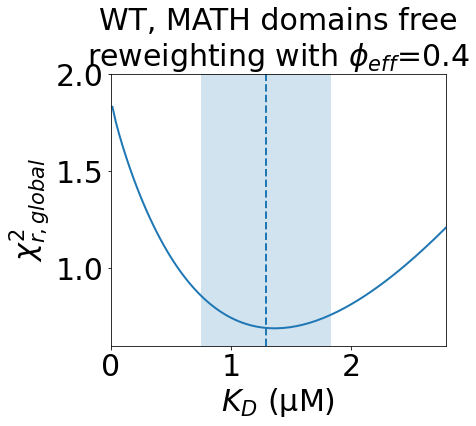

In [5]:
#Start plot
fig = plt.figure(figsize=(6,5))

ystart=0.6
yend=2.0
xwidth=1.5

#Define plot x-axis bounds
if Kd_fitted-xwidth < 0:
    plt.xlim(0, Kd_fitted+xwidth)
else:
    plt.xlim(Kd_fitted-xwidth, Kd_fitted+xwidth)

#Plot
plt.plot(Kd_scan, chi2_global_vs_Kd_scan, lw=2)
plt.xlabel('$K_D$ (µM)', fontsize=30)
plt.ylabel('$\chi^2_{r,global}$', fontsize=30)
plt.tick_params(labelsize=30)

#Title
if reweighting == True:
    if MATH_type=='MATHfree':
        plt.title(f'{SPOP_type}, MATH domains free\nreweighting with $\phi_{{eff}}$={selected_phi_limit}', fontsize=30)
    elif MATH_type=='MATHfixed':
        plt.title(f'{SPOP_type}, MATH domains restrained\nreweighting with $\phi_{{eff}}$={selected_phi_limit}', fontsize=30)
else:
    if MATH_type=='MATHfree':
        plt.title(f'{SPOP_type}, MATH domains free\nbefore reweighting', fontsize=30)
    elif MATH_type=='MATHfixed':
        plt.title(f'{SPOP_type}, MATH domains restrained\nbefore reweighting', fontsize=30)

#Plot fitted Kd and shade errorbar
plt.axvline(Kd_fitted, ls='--', lw=2)
plt.ylim(ystart, yend)
plt.fill_betweenx(np.array([ystart, yend]), Kd_fitted-Kd_error, Kd_fitted+Kd_error, alpha=0.2)

fig.savefig(f"plots/{reweighting_type}/Kd_error.png", bbox_inches='tight', pad_inches=1, dpi=400)
fig.savefig(f"plots/{reweighting_type}/Kd_error.pdf", bbox_inches='tight', pad_inches=1, dpi=400)
